# Youtube Comment Sentiment Analysis



In [68]:
import nltk
import requests
import json
import array
import re, string
import random
import wordcloud

import pandas as pd
import plotly.express as px  # (version 4.7.0)
import plotly.graph_objects as go

import matplotlib.pyplot as plt

# Download dataset from nltk library
nltk.download('twitter_samples')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

# Import twitter sample data from nktk corpus
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud, STOPWORDS  
from ipywidgets import widgets
from ipywidgets import Button, GridBox, Layout, ButtonStyle

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# Fetching positive, negative tweets samples and stop words
def nltk_dataset():
    #tokenizing the words
    positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
    negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

    # Stop words
    stop_words = stopwords.words('english')
    
    # Array to store clean positive and negatiove tweet tokens
    positive_cleaned_tokens_list = []
    negative_cleaned_tokens_list = []

    for tokens in positive_tweet_tokens:
        positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    for tokens in negative_tweet_tokens:
        negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))   

    return positive_cleaned_tokens_list, negative_cleaned_tokens_list

In [0]:
# Removing noise form the tweet tokes. http links, username, etc.
def remove_noise(tweet_tokens, stop_words = ()):
    cleaned_tokens = []
    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub("<.*?>", "", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens  

In [0]:
# Gets all positive and negative words tokens
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens) 

In [0]:
# Classifier
def classifyData(train_data, test_data):
    classifier = NaiveBayesClassifier.train(train_data)
    
    print("Accuracy is:", classify.accuracy(classifier, test_data))
    print(classifier.show_most_informative_features(10))
    return classifier

In [0]:
# Randomizing the dataset for training and testing purpose
def randomizingDataset(positive_cleaned_tokens_list, negative_cleaned_tokens_list):

    positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
    negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

    positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]
    negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]
    
    dataset = positive_dataset + negative_dataset
    random.shuffle(dataset)

    train_data = dataset[:7000]
    test_data = dataset[7000:]
    return train_data, test_data

In [0]:
# Fetching a youtube video comments using youtube API
def youtube_api_comment(VID):
    comment_data = []
    #Youtube Comment Tread API config
    API_KEY = <API_KEY> # Use your youtube data API key
    VideoID = VID
    URL = "https://www.googleapis.com/youtube/v3/commentThreads?part=snippet&key="+API_KEY+"&videoId="+VideoID+"&maxResults=100"
    response = requests.get(URL)
    # Case 1
    err = ""
    if response.status_code == 200:
        json_data = response.json()
    
        for item in json_data['items']:
            comment_data.append(item['snippet']['topLevelComment']['snippet']['textDisplay'])
    else:
        err = response.status_code
    return comment_data, err

In [0]:
def analyseSentiments(classifier, comments):
    
    dataframe = pd.DataFrame(comments, columns=['comment']) 
    dataframe['Sentiment'] = ''

    sentiments = []
    for index, row in dataframe.iterrows():
        custom_tokens = remove_noise(word_tokenize(row['comment']))
        sentiments.append(classifier.classify(dict([token, True] for token in custom_tokens)))

    dataframe['Sentiment'] = sentiments
    dataframe['Sentiment'].value_counts()
    return dataframe

In [0]:
def plotGraph(dataframe):
    df = dataframe.groupby('Sentiment').count().reset_index()
    fig = px.bar(df,
             x='Sentiment',
             y='comment',
             title='Positive vs Negative Sentiments',
             color='Sentiment',
             barmode='stack')
    return fig

In [0]:
def cleanhtml(raw_html):
    raw_html = raw_html.encode('ascii', 'ignore').decode('ascii')
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, "", raw_html)
    cleantext = re.sub(r"http\S+", "", cleantext)
    return cleantext

In [0]:
def createWordCloud(cleantext):
    comment_words = '' 
    stopwords = set(STOPWORDS) 
      
    for val in cleantext:
      val = str(val) 
      # split the value 
      tokens = val.split() 
          
      # Converts each token into lowercase 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
          
      comment_words += " ".join(tokens)+" "
      
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 
      
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
      
    plt.show()

In [0]:
def runProgram(value):
    # Dataset
    positive_cleaned_tokens_list, negative_cleaned_tokens_list = nltk_dataset()

    # Randomizing training and testing data 
    train_data, test_data = randomizingDataset(positive_cleaned_tokens_list, negative_cleaned_tokens_list)

    # Calling classifier
    classifier = classifyData(train_data, test_data)

    comments, err = youtube_api_comment(value)

    if err == "":
        # Analysing sentiment of testing data (youtube comments)
        dataframe = analyseSentiments(classifier, comments)
        fig = plotGraph(dataframe)
        fig.show()

        cleantext = []
        for index, row in dataframe.iterrows():
            cleantext.append(cleanhtml(row['comment']))
        createWordCloud(cleantext)
    else:
        print("Error")

GridBox(children=(Text(value='', description='Video ID:', layout=Layout(grid_area='textfield', width='auto'), …

Accuracy is: 0.995
Most Informative Features
                      :( = True           Negati : Positi =   2052.4 : 1.0
                      :) = True           Positi : Negati =    991.5 : 1.0
                     sad = True           Negati : Positi =     32.8 : 1.0
                     bam = True           Positi : Negati =     21.8 : 1.0
               community = True           Positi : Negati =     16.5 : 1.0
               wonderful = True           Positi : Negati =     12.4 : 1.0
                     ugh = True           Negati : Positi =     12.2 : 1.0
                  arrive = True           Positi : Negati =     11.9 : 1.0
           unfortunately = True           Negati : Positi =     11.6 : 1.0
                followed = True           Negati : Positi =     11.2 : 1.0
None


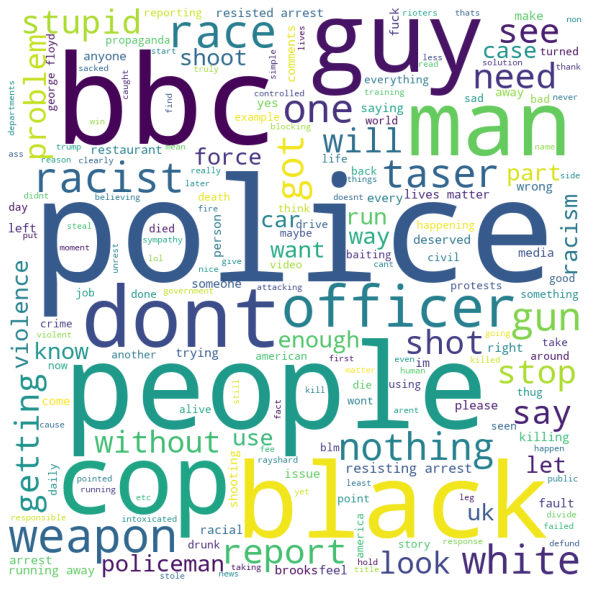

In [67]:
# Button click callback
def on_button_clicked(b):
  runProgram(textfield.value)


# HTML Component
textfield = widgets.Text(
    placeholder='Enter Youtube Video ID',
    description='Video ID:',
    disabled=False,
    layout=Layout(width='auto', grid_area='textfield')
)

button  = Button(description='Submit',
                 layout=Layout(width='auto', grid_area='button'),
                 style=ButtonStyle(button_color='lightblue'))

button.on_click(on_button_clicked)

GridBox(children=[textfield, button],
        layout=Layout(
            width='50%',
            grid_template_rows='auto auto auto',
            grid_template_columns='25% 25% 25% 25%',
            grid_template_areas='''
            "textfield textfield button"
            ''')
       )